# AirQuality Time Series Analysis Mini-Project
Objective: To analyze historical air quality data to identify trends, assess pollution levels, and evaluate the effectiveness of environmental policies over the sampled period.

### Project Overview
In this mini project, we will utilize the "AirQualityUCI" dataset to perform a comprehensive analysis of air quality measurements recorded over time. This dataset provides a rich compilation of air quality metrics such as CO levels, benzene concentrations, and nitrogen oxides, which are crucial for understanding environmental impacts and health implications.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Import machine learning libraries for predictive analysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [2]:
# data exploration

#load dataset
data = pd.read_csv('AirQualityUCI.csv', delimiter=';', decimal=',')

# explore the data
print(data.head(5)) #get first 5 rows
print(data.info()) #get data structure and types
print(data.describe()) #get data summary statistics
print(data.isna().sum()) #get total missing values

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN          NaN  
1  13.3  47.7  0

In [3]:
print(data.columns)

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'Unnamed: 15', 'Unnamed: 16'],
      dtype='object')


In [4]:
# Create a copy for cleaning
df_clean = data.copy()

# Remove completely empty rows
df_clean = df_clean.dropna(how='all')
print(f"After removing empty rows: {df_clean.shape}")

# Remove columns that are completely empty
df_clean = df_clean.dropna(axis=1, how='all')
print(f"After removing empty columns: {df_clean.shape}")

print("\nCleaned columns:")
print(list(df_clean.columns))

After removing empty rows: (9357, 17)
After removing empty columns: (9357, 15)

Cleaned columns:
['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']


In [5]:
# Handle -200 values (replace with NaN)
for col in df_clean.columns:
    if df_clean[col].dtype in ['int64', 'float64']:
        df_clean[col] = df_clean[col].replace(-200, np.nan)

# Convert date and time columns
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y', errors='coerce')
df_clean['Time'] = pd.to_datetime(df_clean['Time'], format='%H.%M.%S', errors='coerce').dt.time

# Create datetime column
df_clean['datetime'] = pd.to_datetime(df_clean['Date'].astype(str) + ' ' + df_clean['Time'].astype(str))

print("\nDate range:")
print(f"Start: {df_clean['Date'].min()}")
print(f"End: {df_clean['Date'].max()}")
print(f"Total days: {(df_clean['Date'].max() - df_clean['Date'].min()).days}")


Date range:
Start: 2004-03-10 00:00:00
End: 2005-04-04 00:00:00
Total days: 390


In [6]:
# Clean column names and convert data types
# Rename columns for clarity
column_mapping = {
    'CO(GT)': 'CO',
    'PT08.S1(CO)': 'PT08_S1_CO',
    'NMHC(GT)': 'NMHC',
    'C6H6(GT)': 'Benzene',
    'PT08.S2(NMHC)': 'PT08_S2_NMHC',
    'NOx(GT)': 'NOx',
    'PT08.S3(NOx)': 'PT08_S3_NOx',
    'NO2(GT)': 'NO2',
    'PT08.S4(NO2)': 'PT08_S4_NO2',
    'PT08.S5(O3)': 'PT08_S5_O3',
    'T': 'Temperature',
    'RH': 'Relative_Humidity',
    'AH': 'Absolute_Humidity'
}

df_clean = df_clean.rename(columns=column_mapping)

# Convert pollutant columns to numeric
pollutant_cols = ['CO', 'PT08_S1_CO', 'NMHC', 'Benzene', 'PT08_S2_NMHC', 
                  'NOx', 'PT08_S3_NOx', 'NO2', 'PT08_S4_NO2', 'PT08_S5_O3']

for col in pollutant_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Convert environmental factors to numeric
env_cols = ['Temperature', 'Relative_Humidity', 'Absolute_Humidity']
for col in env_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

print("\nCleaned columns:")
print(list(df_clean.columns))
print("\nData types:")
print(df_clean.dtypes)


Cleaned columns:
['Date', 'Time', 'CO', 'PT08_S1_CO', 'NMHC', 'Benzene', 'PT08_S2_NMHC', 'NOx', 'PT08_S3_NOx', 'NO2', 'PT08_S4_NO2', 'PT08_S5_O3', 'Temperature', 'Relative_Humidity', 'Absolute_Humidity', 'datetime']

Data types:
Date                 datetime64[ns]
Time                         object
CO                          float64
PT08_S1_CO                  float64
NMHC                        float64
Benzene                     float64
PT08_S2_NMHC                float64
NOx                         float64
PT08_S3_NOx                 float64
NO2                         float64
PT08_S4_NO2                 float64
PT08_S5_O3                  float64
Temperature                 float64
Relative_Humidity           float64
Absolute_Humidity           float64
datetime             datetime64[ns]
dtype: object


In [7]:
# Check missing values after cleaning
print("Missing values after cleaning:")
print("=" * 50)
missing_clean = df_clean.isnull().sum()
missing_percent = (missing_clean / len(df_clean)) * 100

missing_df = pd.DataFrame({
    'Missing_Count': missing_clean,
    'Missing_Percentage': missing_percent
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print(missing_df)

# Remove rows with too many missing values
threshold = 0.5  # Remove rows with more than 50% missing values
df_clean = df_clean.dropna(thresh=len(df_clean.columns) * threshold)
print(f"\nAfter removing rows with >50% missing values: {df_clean.shape}")

Missing values after cleaning:
                   Missing_Count  Missing_Percentage
NMHC                        8443           90.231912
CO                          1683           17.986534
NO2                         1642           17.548360
NOx                         1639           17.516298
PT08_S1_CO                   366            3.911510
Benzene                      366            3.911510
PT08_S2_NMHC                 366            3.911510
PT08_S3_NOx                  366            3.911510
PT08_S4_NO2                  366            3.911510
PT08_S5_O3                   366            3.911510
Temperature                  366            3.911510
Relative_Humidity            366            3.911510
Absolute_Humidity            366            3.911510

After removing rows with >50% missing values: (8991, 16)


## Statistical Summary and Data Analysis

In [8]:
# Statistical summary of cleaned data
print("Statistical Summary of Air Quality Data")
print("=" * 50)

# Summary statistics for pollutants
pollutant_summary = df_clean[pollutant_cols].describe()
print("\nPollutant Summary Statistics:")
print(pollutant_summary)

# Summary statistics for environmental factors
env_summary = df_clean[env_cols].describe()
print("\nEnvironmental Factors Summary Statistics:")
print(env_summary)

Statistical Summary of Air Quality Data

Pollutant Summary Statistics:
                CO   PT08_S1_CO         NMHC      Benzene  PT08_S2_NMHC  \
count  7344.000000  8991.000000   887.000000  8991.000000   8991.000000   
mean      2.129711  1099.833166   218.607666    10.083105    939.153376   
std       1.436472   217.080037   206.615130     7.449820    266.831429   
min       0.100000   647.000000     7.000000     0.100000    383.000000   
25%       1.100000   937.000000    66.000000     4.400000    734.500000   
50%       1.800000  1063.000000   145.000000     8.200000    909.000000   
75%       2.800000  1231.000000   297.000000    14.000000   1116.000000   
max      11.900000  2040.000000  1189.000000    63.700000   2214.000000   

               NOx  PT08_S3_NOx          NO2  PT08_S4_NO2   PT08_S5_O3  
count  7396.000000  8991.000000  7393.000000  8991.000000  8991.000000  
mean    242.189292   835.493605   112.145137  1456.264598  1022.906128  
std     206.312007   256.817320   

In [9]:
# Time series analysis - Daily averages
daily_avg = df_clean.groupby(df_clean['Date']).agg({
    'CO': 'mean',
    'NO2': 'mean',
    'NOx': 'mean',
    'PT08_S5_O3': 'mean',
    'Benzene': 'mean',
    'Temperature': 'mean',
    'Relative_Humidity': 'mean'
}).reset_index()

print("\nDaily averages shape:", daily_avg.shape)
print("\nFirst few daily averages:")
print(daily_avg.head())

# Monthly averages
print("\nCalculating monthly averages...")
monthly_avg = df_clean.groupby(df_clean['Date'].dt.to_period('M')).agg({
    'CO': 'mean',
    'NO2': 'mean',
    'NOx': 'mean',
    'PT08_S5_O3': 'mean',
    'Benzene': 'mean',
    'Temperature': 'mean',
    'Relative_Humidity': 'mean'
}).reset_index()

print("\nMonthly averages shape:", monthly_avg.shape)
print("\nMonthly averages:")
print(monthly_avg)


Daily averages shape: (383, 8)

First few daily averages:
        Date        CO         NO2         NOx   PT08_S5_O3    Benzene  \
0 2004-03-10  1.966667  108.833333  132.000000  1096.000000   8.450000   
1 2004-03-11  2.239130   99.869565  144.391304   885.250000   7.979167   
2 2004-03-12  2.804545  116.272727  173.727273  1084.375000  12.129167   
3 2004-03-13  2.695652  118.869565  184.434783  1245.916667  10.916667   
4 2004-03-14  2.469565  110.391304  146.608696  1234.208333   9.637500   

   Temperature  Relative_Humidity  
0    12.033333          54.900000  
1     9.837500          64.075000  
2    11.287500          51.095833  
3    12.866667          51.533333  
4    16.012500          48.850000  

Calculating monthly averages...

Monthly averages shape: (14, 8)

Monthly averages:
       Date        CO         NO2         NOx   PT08_S5_O3    Benzene  \
0   2004-03  2.292073  102.581967  143.493852  1027.494118   9.932745   
1   2004-04  2.298932   96.152174  138.341304  10

In [10]:
# Correlation analysis between pollutants and environmental factors
# Select numeric columns for correlation
correlation_cols = pollutant_cols + env_cols
correlation_data = df_clean[correlation_cols].corr()

print("\nCorrelation matrix shape:", correlation_data.shape)
print("\nCorrelation with Temperature:")
temp_corr = correlation_data['Temperature'].sort_values(ascending=False)
print(temp_corr)

print("\nCorrelation with Relative Humidity:")
rh_corr = correlation_data['Relative_Humidity'].sort_values(ascending=False)
print(rh_corr)


Correlation matrix shape: (13, 13)

Correlation with Temperature:
Temperature          1.000000
Absolute_Humidity    0.656397
PT08_S4_NO2          0.561270
NMHC                 0.391587
PT08_S2_NMHC         0.241373
Benzene              0.198956
PT08_S1_CO           0.048627
CO                   0.022109
PT08_S5_O3          -0.027172
PT08_S3_NOx         -0.145112
NO2                 -0.186533
NOx                 -0.269683
Relative_Humidity   -0.578621
Name: Temperature, dtype: float64

Correlation with Relative Humidity:
Relative_Humidity    1.000000
NOx                  0.221032
Absolute_Humidity    0.167971
PT08_S5_O3           0.124956
PT08_S1_CO           0.114606
CO                   0.048890
PT08_S4_NO2         -0.032188
PT08_S3_NOx         -0.056740
Benzene             -0.061681
PT08_S2_NMHC        -0.090380
NO2                 -0.091759
NMHC                -0.191454
Temperature         -0.578621
Name: Relative_Humidity, dtype: float64


## Data Visualization

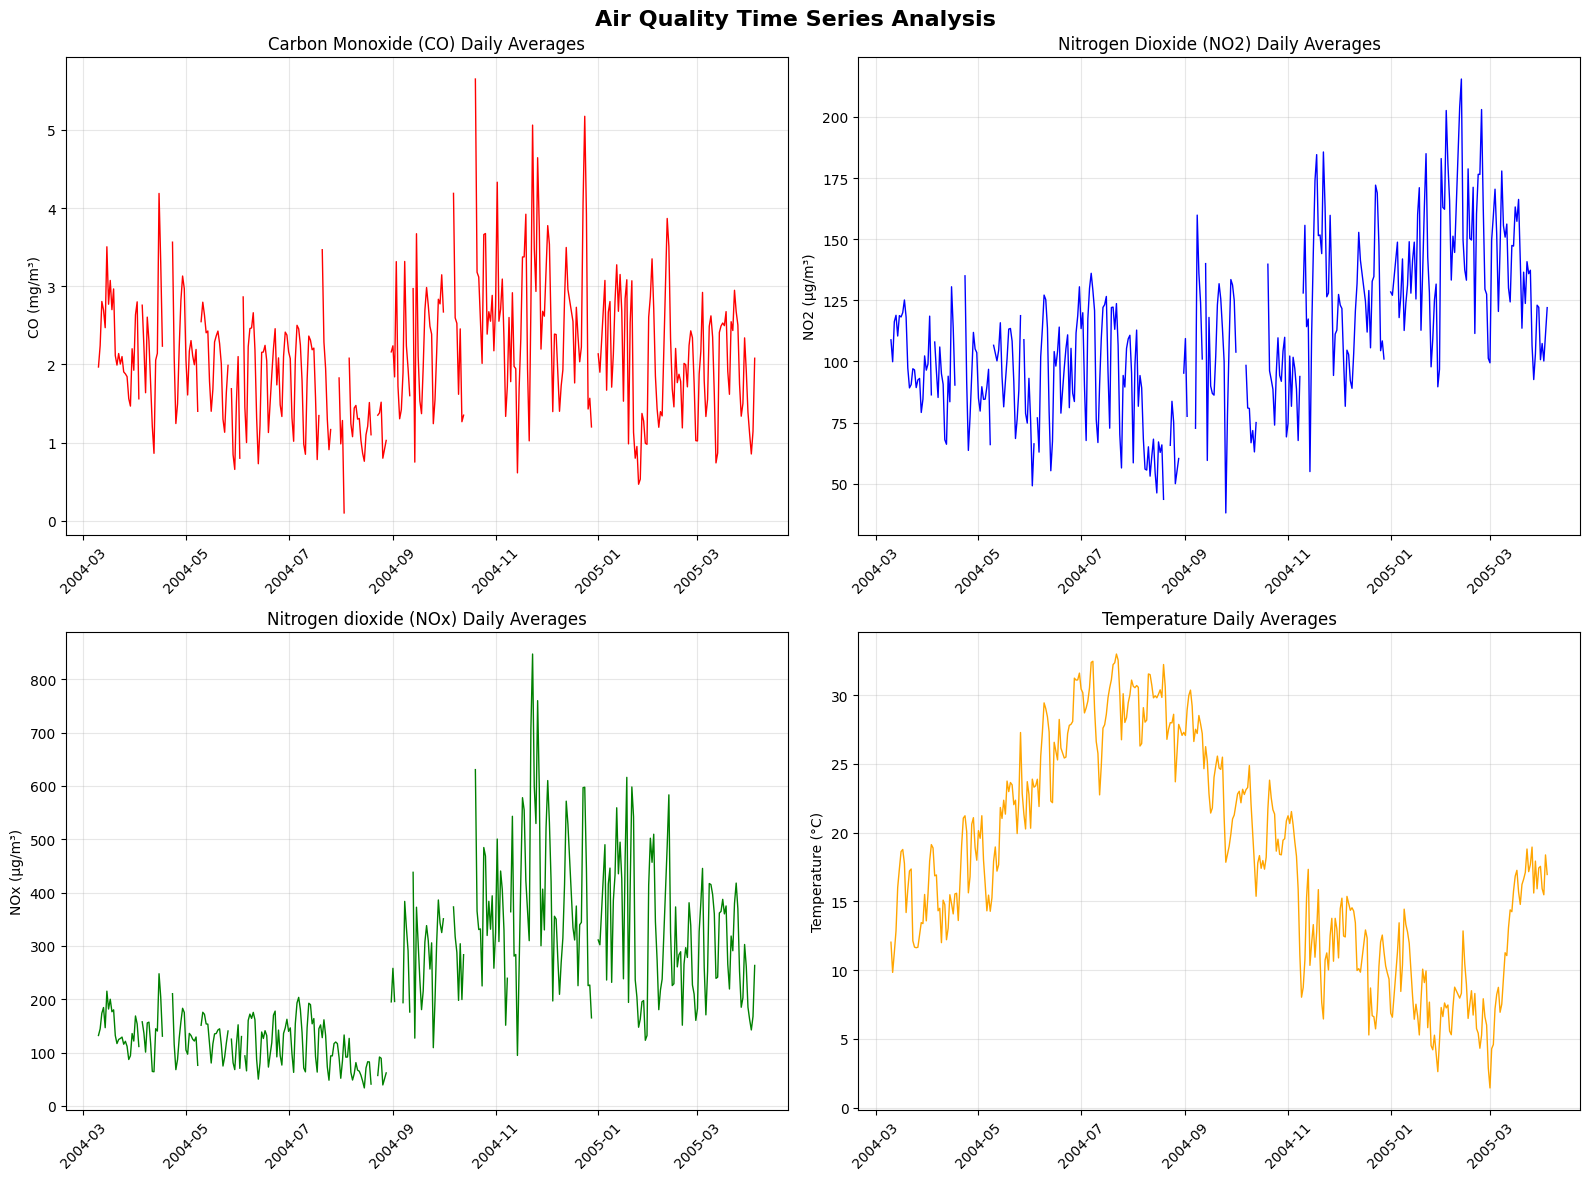

In [12]:
# Time series plots for pollutants
# Set up the plotting area
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Air Quality Time Series Analysis', fontsize=16, fontweight='bold')

# CO levels over time
axes[0, 0].plot(daily_avg['Date'], daily_avg['CO'], color='red', linewidth=1)
axes[0, 0].set_title('Carbon Monoxide (CO) Daily Averages')
axes[0, 0].set_ylabel('CO (mg/m³)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# NO2 levels over time
axes[0, 1].plot(daily_avg['Date'], daily_avg['NO2'], color='blue', linewidth=1)
axes[0, 1].set_title('Nitrogen Dioxide (NO2) Daily Averages')
axes[0, 1].set_ylabel('NO2 (µg/m³)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# NOx levels over time
axes[1, 0].plot(daily_avg['Date'], daily_avg['NOx'], color='green', linewidth=1)
axes[1, 0].set_title('Nitrogen dioxide (NOx) Daily Averages')
axes[1, 0].set_ylabel('NOx (µg/m³)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Temperature over time
axes[1, 1].plot(daily_avg['Date'], daily_avg['Temperature'], color='orange', linewidth=1)
axes[1, 1].set_title('Temperature Daily Averages')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

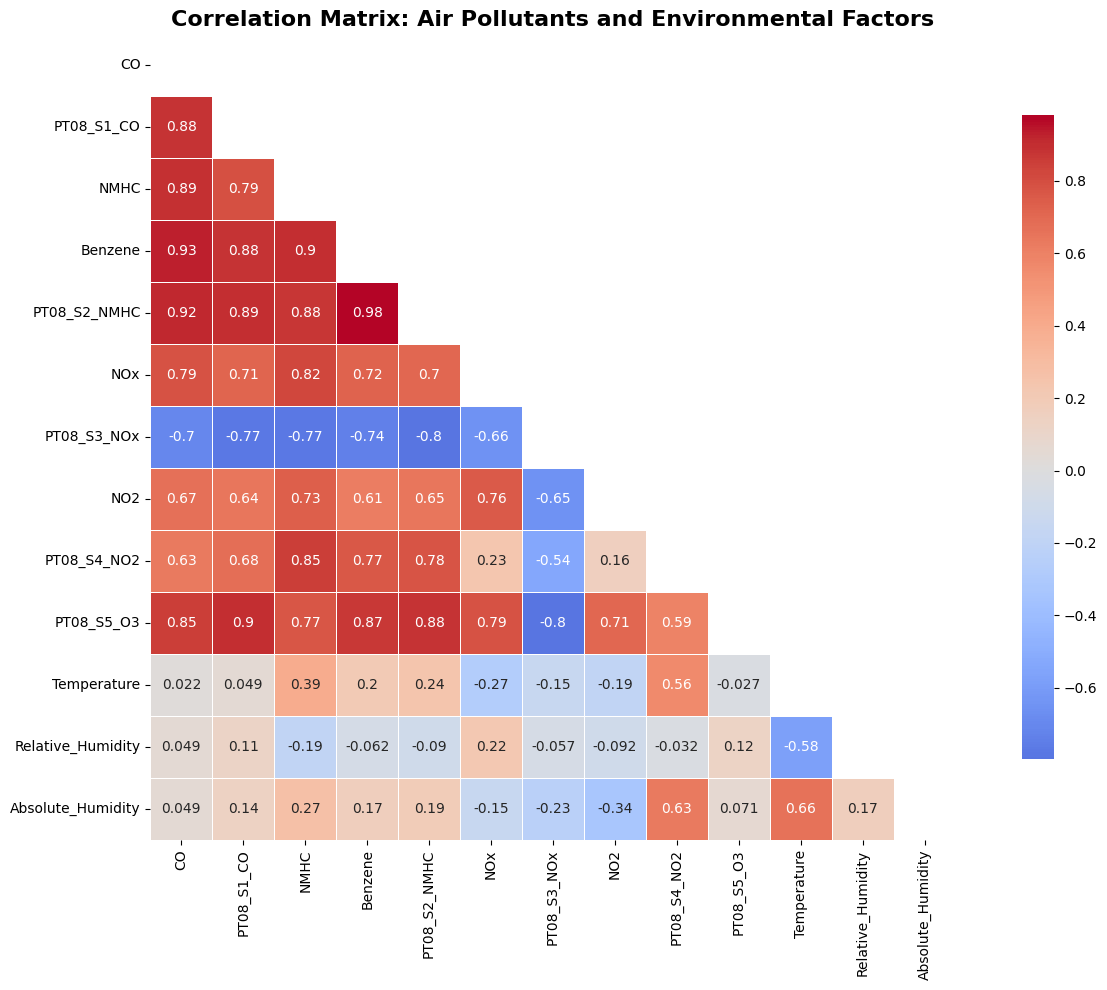

In [13]:
# Correlation heatmap
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_data, dtype=bool))
sns.heatmap(correlation_data, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix: Air Pollutants and Environmental Factors', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

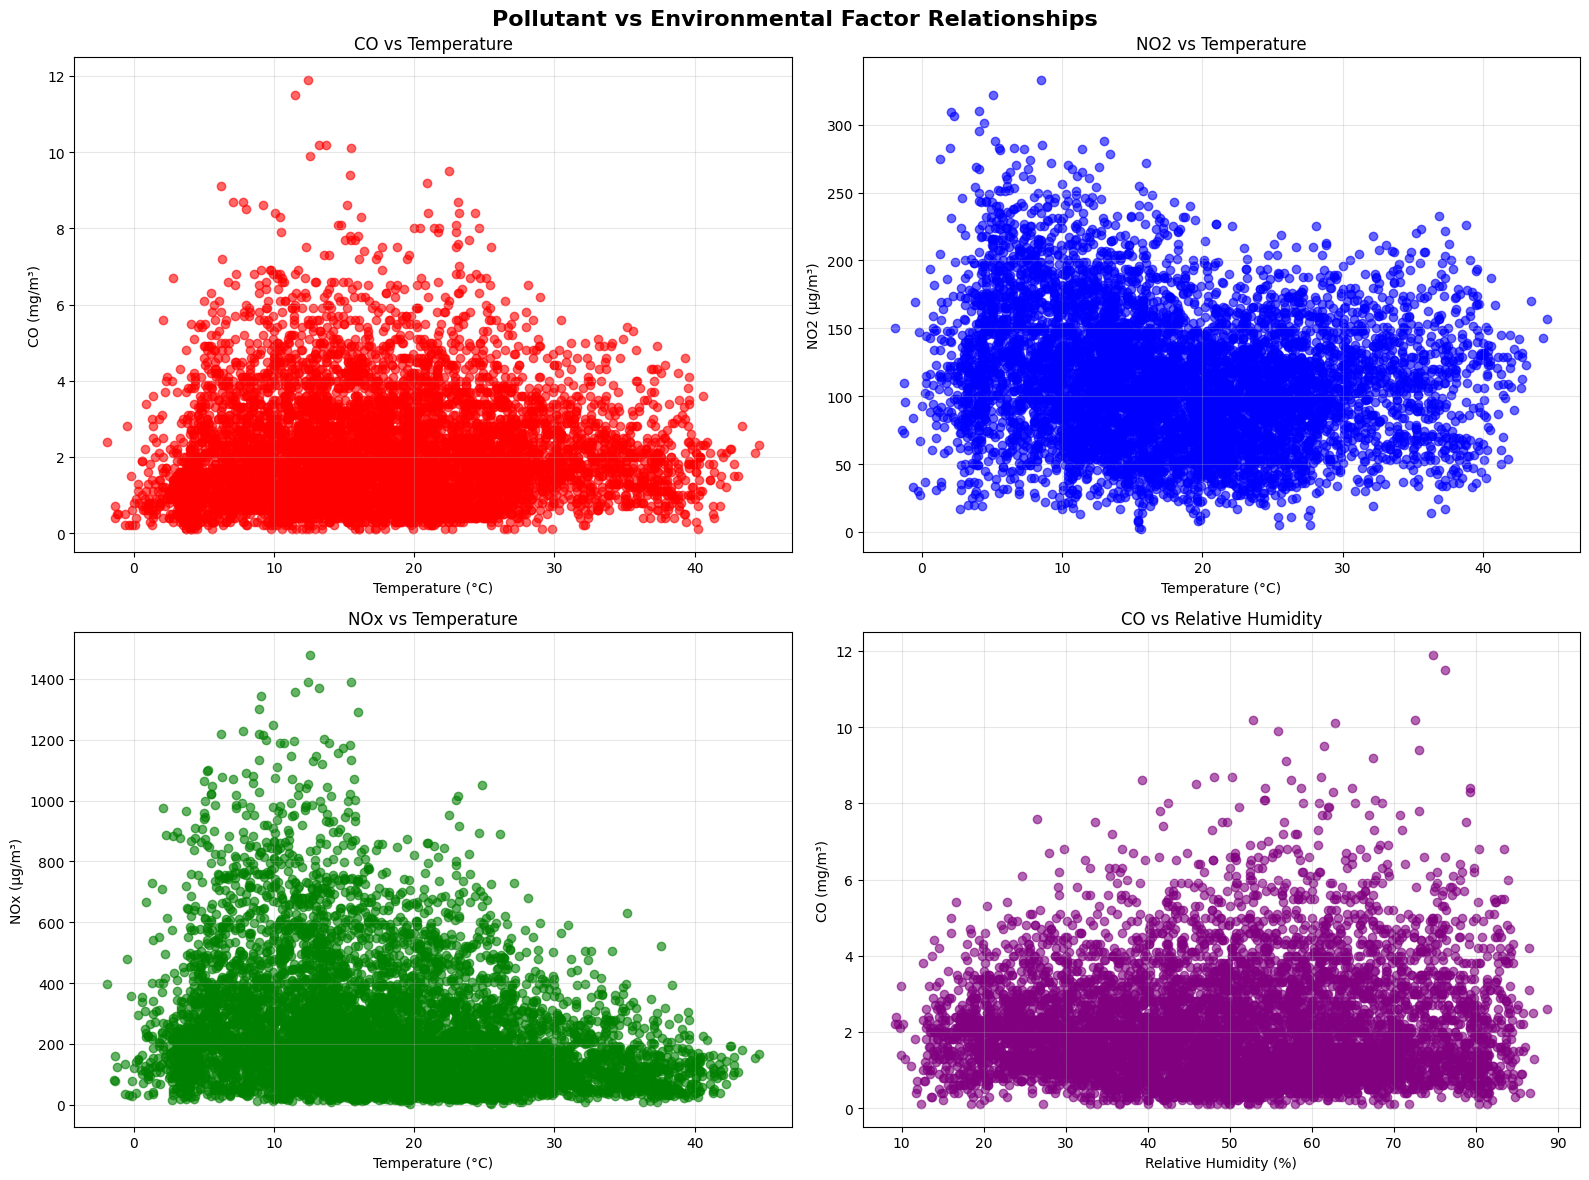

In [14]:
# Scatter plots for key relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Pollutant vs Environmental Factor Relationships', fontsize=16, fontweight='bold')

# CO vs Temperature
axes[0, 0].scatter(df_clean['Temperature'], df_clean['CO'], alpha=0.6, color='red')
axes[0, 0].set_xlabel('Temperature (°C)')
axes[0, 0].set_ylabel('CO (mg/m³)')
axes[0, 0].set_title('CO vs Temperature')
axes[0, 0].grid(True, alpha=0.3)

# NO2 vs Temperature
axes[0, 1].scatter(df_clean['Temperature'], df_clean['NO2'], alpha=0.6, color='blue')
axes[0, 1].set_xlabel('Temperature (°C)')
axes[0, 1].set_ylabel('NO2 (µg/m³)')
axes[0, 1].set_title('NO2 vs Temperature')
axes[0, 1].grid(True, alpha=0.3)

# NOx vs Temperature
axes[1, 0].scatter(df_clean['Temperature'], df_clean['NOx'], alpha=0.6, color='green')
axes[1, 0].set_xlabel('Temperature (°C)')
axes[1, 0].set_ylabel('NOx (µg/m³)')
axes[1, 0].set_title('NOx vs Temperature')
axes[1, 0].grid(True, alpha=0.3)

# CO vs Relative Humidity
axes[1, 1].scatter(df_clean['Relative_Humidity'], df_clean['CO'], alpha=0.6, color='purple')
axes[1, 1].set_xlabel('Relative Humidity (%)')
axes[1, 1].set_ylabel('CO (mg/m³)')
axes[1, 1].set_title('CO vs Relative Humidity')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

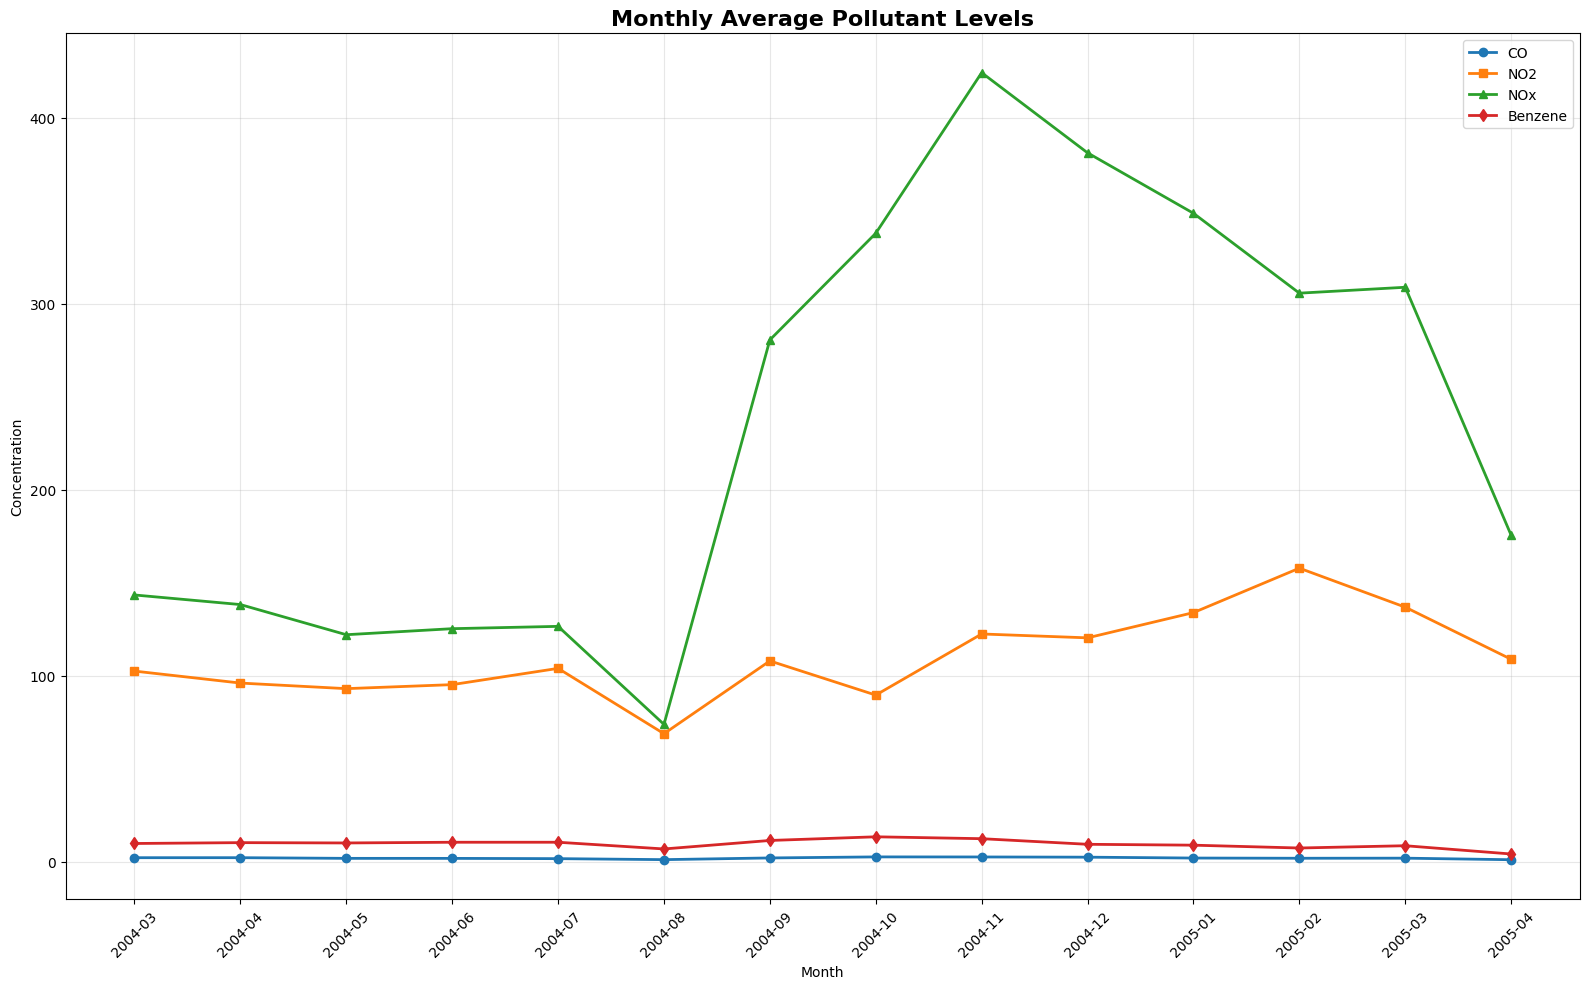

In [16]:
# Monthly trends visualization
plt.figure(figsize=(16, 10))

# Plot monthly averages for key pollutants
months = monthly_avg['Date'].astype(str)
plt.plot(months, monthly_avg['CO'], marker='o', label='CO', linewidth=2, markersize=6)
plt.plot(months, monthly_avg['NO2'], marker='s', label='NO2', linewidth=2, markersize=6)
plt.plot(months, monthly_avg['NOx'], marker='^', label='NOx', linewidth=2, markersize=6)
plt.plot(months, monthly_avg['Benzene'], marker='d', label='Benzene', linewidth=2, markersize=6)

plt.title('Monthly Average Pollutant Levels', fontsize=16, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Predictive Analysis

In [17]:
# Prepare data for predictive modeling
# Select features and target for CO prediction
feature_cols = ['Temperature', 'Relative_Humidity', 'NO2', 'NOx']
target_col = 'CO'

# Remove rows with missing values in selected columns
model_data = df_clean[feature_cols + [target_col]].dropna()
print(f"Data shape for modeling: {model_data.shape}")

X = model_data[feature_cols]
y = model_data[target_col]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Data shape for modeling: (6941, 5)
Training set size: 5552
Test set size: 1389


In [18]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear Regression Model
print("Training Linear Regression model...")
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
lr_pred = lr_model.predict(X_test_scaled)

# Evaluate Linear Regression
lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("\nLinear Regression Results:")
print(f"MSE: {lr_mse:.4f}")
print(f"RMSE: {lr_rmse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R²: {lr_r2:.4f}")

Training Linear Regression model...

Linear Regression Results:
MSE: 0.6335
RMSE: 0.7959
MAE: 0.5622
R²: 0.6645


### Random Forest Model

In [19]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test_scaled)

# Evaluate Random Forest
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print("\nRandom Forest Results:")
print(f"MSE: {rf_mse:.4f}")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"R²: {rf_r2:.4f}")


Random Forest Results:
MSE: 0.5057
RMSE: 0.7111
MAE: 0.4621
R²: 0.7321


Feature importance in Random Forest model:
             Feature  Importance
3                NOx    0.607194
2                NO2    0.197964
0        Temperature    0.126369
1  Relative_Humidity    0.068472


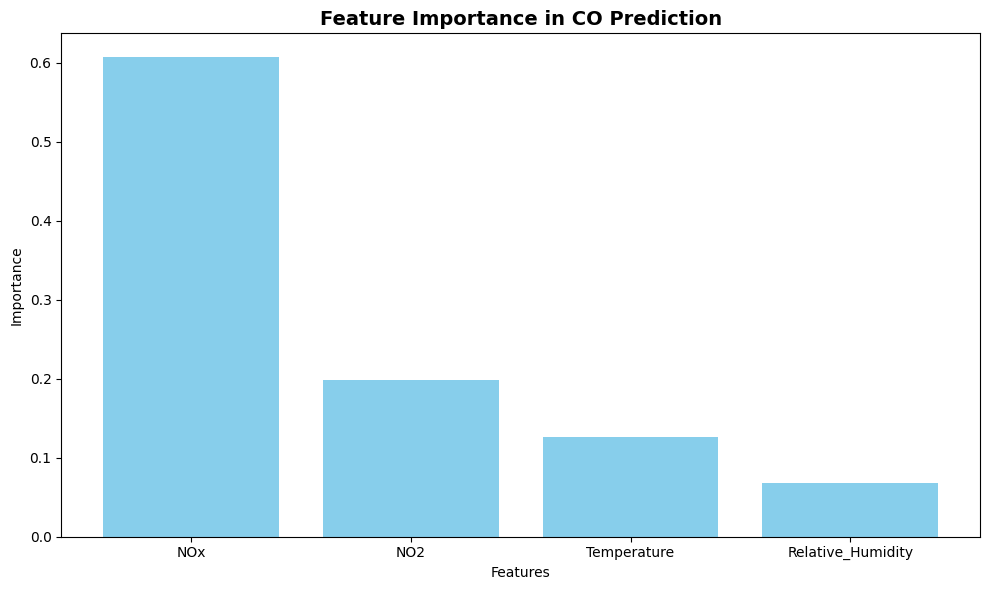

In [20]:
# Feature importance for Random Forest
print("Feature importance in Random Forest model:")
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.title('Feature Importance in CO Prediction', fontsize=14, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

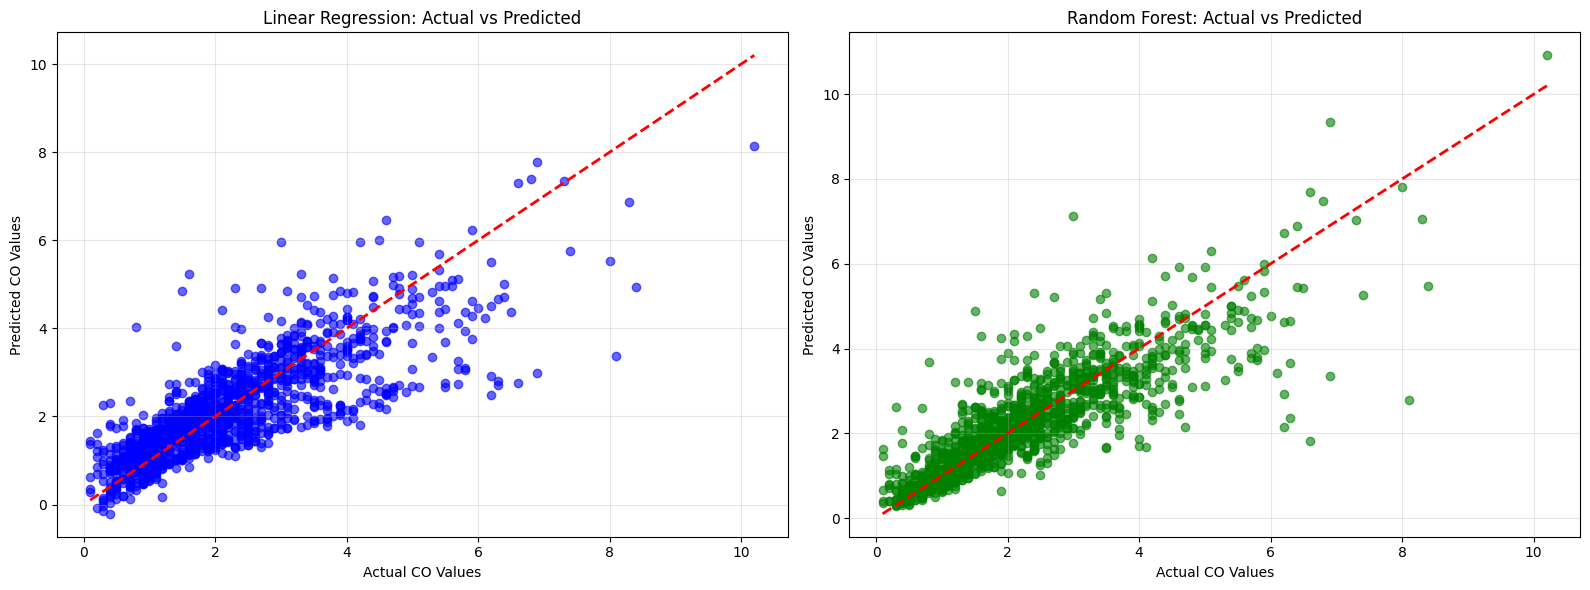

In [21]:
# Model comparison visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Actual vs Predicted for Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.6, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual CO Values')
axes[0].set_ylabel('Predicted CO Values')
axes[0].set_title('Linear Regression: Actual vs Predicted')
axes[0].grid(True, alpha=0.3)

# Actual vs Predicted for Random Forest
axes[1].scatter(y_test, rf_pred, alpha=0.6, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual CO Values')
axes[1].set_ylabel('Predicted CO Values')
axes[1].set_title('Random Forest: Actual vs Predicted')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()